In [47]:
%run data_preprocessing.ipynb

In [48]:
import os
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing

In [49]:
# for get_data
enable_feature_engineering = True
enable_outlier_handling = True
normalize = 'minmax'
use_one_hot_encoding = True
split_size = (0.9, 0.0, 0.1)

In [50]:
y_train, x_train, y_val, x_val, y_test, x_test = get_data(enable_feature_engineering, enable_outlier_handling, normalize, use_one_hot_encoding, split_size)

In [51]:
x_train

,age,height,weight,ap_hi,ap_lo,smoke,alco,active,is_female,bmi,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
58747,0.970422,152,74,0.352941,0.328947,False,False,False,True,0.247231,0,0,1,0,0,1
16604,0.684553,154,56,0.352941,0.328947,False,False,True,True,0.164023,1,0,0,1,0,0
30231,0.357569,158,58,0.294118,0.263158,False,False,True,True,0.160273,1,0,0,1,0,0
65722,0.897019,154,55,0.352941,0.328947,False,False,True,True,0.159854,1,0,0,1,0,0
53261,0.511421,178,93,0.352941,0.328947,True,True,True,False,0.220768,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37961,0.749671,158,52,0.352941,0.328947,False,False,True,True,0.136511,1,0,0,1,0,0
6399,0.865428,164,62,0.352941,0.328947,True,False,False,False,0.158476,1,0,0,1,0,0
56015,0.959892,154,81,0.588235,0.394737,False,False,True,True,0.268241,1,0,0,1,0,0
875,0.870306,156,60,0.411765,0.328947,False,False,True,True,0.174325,0,0,1,0,0,1


In [52]:
y_train

58747    False
16604    False
30231    False
65722     True
53261     True
         ...  
37961     True
6399     False
56015     True
875       True
16122     True
Name: cardio, Length: 61706, dtype: bool

In [53]:
naive_bayes = GaussianNB()
naive_bayes.fit(x_train, y_train)

GaussianNB()

In [54]:
# encode the target variable into a numeric value
label_encoder = preprocessing.LabelEncoder()
y_test = label_encoder.fit_transform(y_test)

In [55]:
#apply the model (predict)
x_test_prediction = naive_bayes.predict(x_test)

In [56]:
#taken from the exercise script
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    #plt.show()

Accuracy: 0.6771182732973604


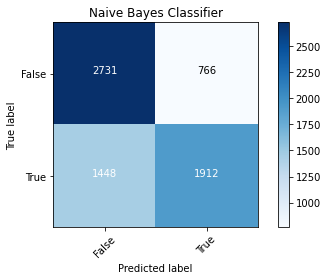

In [58]:
#compute the confusion matrix
cnf_matrix = confusion_matrix(y_test, x_test_prediction)

#compute accuracy score
print("Accuracy: {}".format(accuracy_score(y_test, x_test_prediction)))

#plot the confusion matrix
plot_confusion_matrix(cnf_matrix, classes=label_encoder.classes_, title='Naive Bayes Classifier')